In [364]:
import pandas as pd
import json
import ndjson
import dask.bag as db
from dask.diagnostics import ProgressBar
from textblob import TextBlob
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [370]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [32]:
files = glob.glob("D:\\Research\\causal_inference_data2\\retweeters_filtered.json\\*.part")
files = [s.replace("\\","/") for s in np.random.choice(files, 100, replace=False)]

In [430]:
user_tweets_bag = db.read_text(files)\
                    .map(json.loads)\
                    .map(
                        lambda x: {
                            "id": x["id"],
                            "user": x["user"],
                            "created_at": x["created_at"],
                            "retweet_id": x.get("retweeted_status", {}).get("id", -1),
                            #"sentiment_polarity": TextBlob(x["full_text"]).sentiment.polarity,
                            "sentiment_polarity": analyser.polarity_scores(x["full_text"])["compound"],
                            "sentiment_subjectivity": TextBlob(x["full_text"]).sentiment.subjectivity
                        }
                    )

In [431]:
user_tweets = user_tweets_bag.to_dataframe(meta={
    "id": "int64", "user": "object", "created_at": "datetime64[ns, UTC]", "retweet_id": "int64", 
    "sentiment_polarity": "float64", "sentiment_subjectivity": "float64"
}).sample(frac=0.01)

In [368]:
#user_tweets.to_json("D:/Research/causal_inference_data2/retweeters_filtered_sampled.json/*.part")

In [375]:
df.to_json("./pattern_sample_sentiment_retweets.json", lines=True, orient="records")

## Sampling Users For Sentiment General Stats

In [432]:
with ProgressBar():
    df = user_tweets.compute()

[########################################] | 100% Completed |  7min 24.0s


In [384]:
df2 = pd.read_json("./pattern_sample_sentiment_retweets.json", lines=True, orient="records")

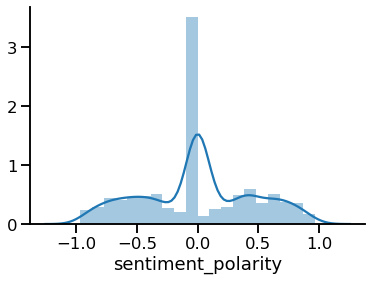

In [433]:
sns.distplot(df["sentiment_polarity"])
sns.despine()

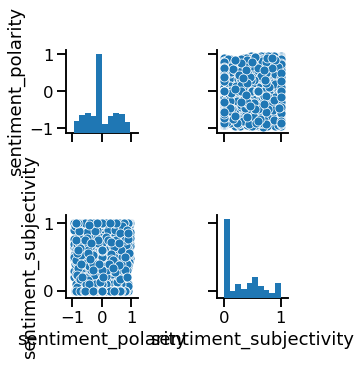

In [434]:
sns.pairplot(df[["sentiment_polarity", "sentiment_subjectivity"]])
sns.despine()

In [435]:
trump_df = pd.read_pickle("./trump_df_vader.pickle")
trump_df = trump_df.rename(columns = {"polarity": "sentiment_polarity", "subjectivity": "sentiment_subjectivity"})
trump_df["created_at"] = trump_df["created_at"].astype("datetime64[ns, UTC]")

In [436]:
df_all = pd.concat([
    trump_df[["created_at", "sentiment_polarity", "sentiment_subjectivity"]], 
    df.loc[df["created_at"] >= '2019-12-20', ["created_at", "sentiment_polarity", "sentiment_subjectivity"]]], 
    keys=["trump", "retweeters"]
)

In [437]:
df_all2 = df_all.reset_index().drop("level_1", axis=1)

In [438]:
df_all2 = df_all2.rename(columns={"level_0":"source", "sentiment_polarity": "Polarity", "sentiment_subjectivity": "Subjectivity"})

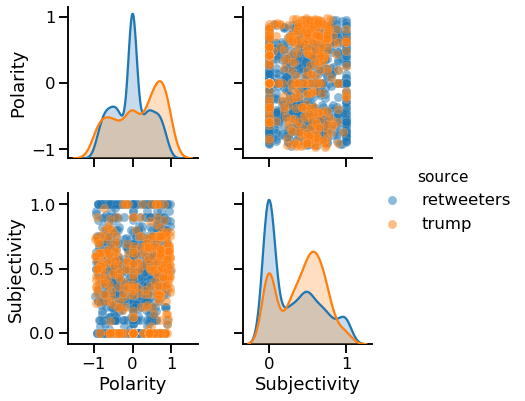

In [439]:
sns.set_context("talk")
#fig = plt.figure(figsize=(10, 8))
sns.pairplot(df_all2, hue="source", plot_kws={"alpha": 0.5, "linewidth": 0.2}, hue_order=["retweeters", "trump"], height=3)
plt.savefig("D:\\Research\\causal_inference_data2\\sentiment_sample_vader.png")

In [440]:
df_all2["Day"] = df_all2["created_at"].dt.round("D")

C:\Python37\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


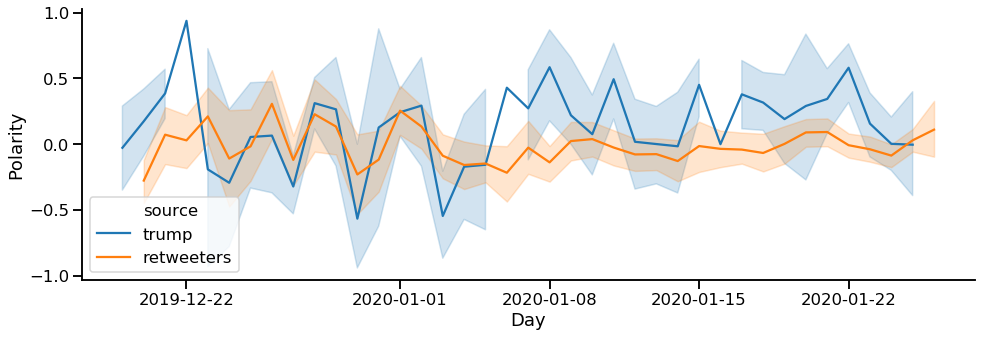

In [441]:
plt.figure(figsize=(16,5))
sns.lineplot(x="Day", y="Polarity", data=df_all2, hue="source")
sns.despine()
plt.savefig("D:\\Research\\causal_inference_data2\\polarity_overtime_vader.png")

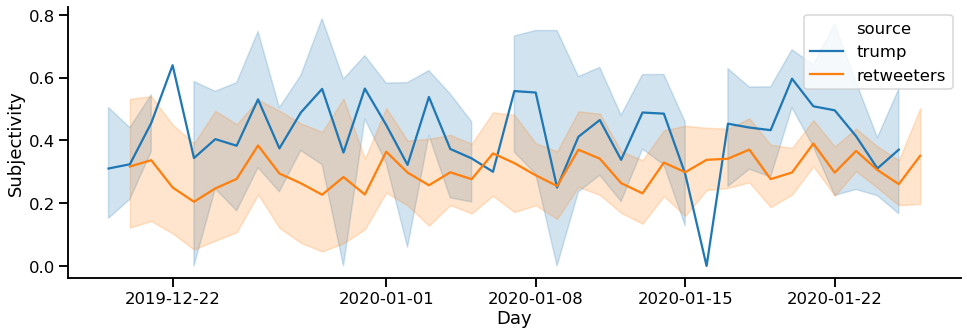

In [442]:
plt.figure(figsize=(16,5))
sns.lineplot(x="Day", y="Subjectivity", data=df_all2, hue="source")
sns.despine()
plt.savefig("D:\\Research\\causal_inference_data2\\subjectivity_overtime_vader.png")

In [209]:
df_all2.groupby(["source", "Day"])["Subjectivity"].mean().nsmallest()

source      Day                      
trump       2020-01-16 00:00:00+00:00    0.000000
retweeters  2019-12-26 00:00:00+00:00    0.164957
            2020-01-18 00:00:00+00:00    0.189615
            2020-01-15 00:00:00+00:00    0.213258
            2019-12-22 00:00:00+00:00    0.235724
Name: Subjectivity, dtype: float64

In [214]:
trump_df[trump_df["created_at"].dt.round("D") == "2020-01-16"].

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,sentiment_polarity,sentiment_subjectivity
334,2020-01-15 15:33:21+00:00,1217469828656701442,1217469828656701442,"Here we go again, another Con Job by the Do No...",False,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,32075,161735,False,False,NaN,en,NaN,NaN,0.0,0.0


In [207]:
trump_df.groupby("Da".nsmallest(10, "sentiment_subjectivity")

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,sentiment_polarity,sentiment_subjectivity
0,2020-01-24 12:58:27+00:00,1220692336881160193,1220692336881160193,"Cryin’ Chuck never had what it takes, and neve...",False,"[0, 53]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,2061,6992,False,False,False,en,NaN,NaN,0.000,0.0
5,2020-01-24 12:41:33+00:00,1220688087220617218,1220688087220617218,"“I often get asked the question, well, isn’t t...",False,"[0, 280]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,2765,11248,False,False,NaN,en,NaN,NaN,-0.125,0.0
42,2020-01-24 11:24:48+00:00,1220668770638876672,1220668770638876672,“21 State Attorney Generals denouncing the Imp...,False,"[0, 84]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,5297,23948,False,False,NaN,en,NaN,NaN,0.000,0.0
50,2020-01-23 21:11:47+00:00,1220454103937167361,1220454103937167361,"On my way, see you soon! https://t.co/6Rd5lbafJv",False,"[0, 24]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,9617,40503,False,False,False,en,NaN,NaN,0.000,0.0
56,2020-01-23 21:01:35+00:00,1220451535005671428,1220451535005671428,Close race in Kansas! https://t.co/m2ExF9vHKU,False,"[0, 21]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,5561,20575,False,False,False,en,NaN,"{'media': [{'id': 1220451519046139904, 'id_str...",0.000,0.0
57,2020-01-23 20:34:14+00:00,1220444653348098048,1220444653348098048,“President Trump shows us that electability is...,False,"[0, 115]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,8724,34241,False,False,False,en,NaN,NaN,0.000,0.0
58,2020-01-23 20:26:23+00:00,1220442676081963010,1220442676081963010,“The Democrats have now conceded that Presiden...,False,"[0, 95]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,20356,83799,False,False,NaN,en,NaN,NaN,0.000,0.0
61,2020-01-23 16:15:29+00:00,1220379537155948544,1220379537155948544,“This is all about undermining the next Electi...,False,"[0, 69]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,19272,87626,False,False,NaN,en,NaN,NaN,0.000,0.0
72,2020-01-23 12:39:17+00:00,1220325126186598400,1220325126186598400,"“Schiff doesn’t have a case telling the truth,...",False,"[0, 106]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,15805,69897,False,False,NaN,en,NaN,NaN,0.000,0.0
82,2020-01-22 22:04:40+00:00,1220105021930426368,1220105021930426368,See you on Friday...Big Crowd! https://t.co/MF...,False,"[0, 30]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,25666,100317,False,False,False,en,NaN,NaN,0.000,0.0


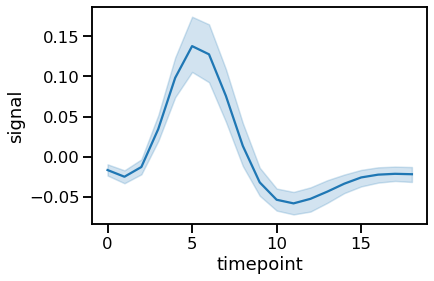

In [150]:
ax = sns.lineplot("timepoint", "signal", data=fmri)

## Retweeters

In [216]:
retweets = json.load(open("D:/Research/causal_inference_data2/realDonaldTrump.ndjson.retweets.json"))

In [217]:
sample = trump_df.sample(10)

In [227]:
sample

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,sentiment_polarity,sentiment_subjectivity
855,2019-12-20 21:23:11+00:00,1208135784152358913,1208135784152358913,"Economy is GREAT, Big Stock Market uptick toda...",False,"[0, 109]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,12594,47925,False,False,False,en,NaN,NaN,0.600000,0.383333
376,2020-01-13 23:58:04+00:00,1216872069591289858,1216872069591289858,I stand stronger than anyone in protecting you...,False,"[0, 186]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,36417,211182,False,False,NaN,en,NaN,NaN,-0.325000,0.700000
271,2020-01-18 13:19:20+00:00,1218523265821544450,1218523265821544450,Tremendous surge in new housing construction i...,False,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,23467,125071,False,False,NaN,en,NaN,NaN,0.364899,0.651515
484,2020-01-09 22:49:55+00:00,1215405367229739008,1215405367229739008,95% Approval Rating in the Republican Party. T...,False,"[0, 55]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,26670,221451,False,False,NaN,en,NaN,NaN,0.000000,0.000000
64,2020-01-23 13:25:14+00:00,1220336691539599361,1220336691539599361,Mini Mike Bloomberg is playing poker with his ...,False,"[0, 275]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,17576,77683,False,False,NaN,en,NaN,NaN,-0.113889,0.280556
492,2020-01-09 15:00:36+00:00,1215287261606051844,1215287261606051844,U.S. Cancer Death Rate Lowest In Recorded Hist...,False,"[0, 104]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,25699,164985,False,False,NaN,en,NaN,NaN,0.700000,0.600000
973,2019-12-18 17:44:18+00:00,1207355923573989376,1207355923573989376,"SUCH ATROCIOUS LIES BY THE RADICAL LEFT, DO NO...",False,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,50409,231330,False,False,NaN,en,NaN,NaN,-0.233333,0.500000
939,2019-12-19 14:11:18+00:00,1207664706837733376,1207664706837733376,This is what the Dems are dealing with. Does a...,False,"[0, 83]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,19365,70557,False,False,False,en,NaN,NaN,0.875000,0.600000
165,2020-01-22 09:34:38+00:00,1219916272441470976,1219916272441470976,ENJOY! https://t.co/xqEoCLJy0Y,False,"[0, 6]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,6795,28876,False,False,False,en,NaN,NaN,0.500000,0.500000
53,2020-01-23 21:04:47+00:00,1220452340555309066,1220452340555309066,"A poll of Radical Left, Do Nothing Democrats j...",False,"[0, 84]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,11995,45469,False,False,False,en,NaN,"{'media': [{'id': 1220452325476536320, 'id_str...",0.375000,0.500000


In [230]:
relevant_users = pd.Series(retweets).loc[sample["id_str"].values]

In [238]:
from itertools import chain
from collections import Counter

s = pd.Series(Counter(chain(*retweets.values())))
bad_users  =s[s > 1].index

In [246]:
relevant_users_split = relevant_users.apply(lambda x: pd.Series([set(x) - set(bad_users), set(bad_users) & set(x)], ["once", "repeating"]))

In [251]:
relevant_users_split = relevant_users_split.assign(once_len=lambda df: df["once"].apply(len), repeating_len=lambda df: df["repeating"].apply(len))

In [257]:
sample_with_users = sample.join(relevant_users_split, on=["id_str"])

In [258]:
sample_with_users

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,possibly_sensitive,lang,retweeted_status,extended_entities,sentiment_polarity,sentiment_subjectivity,once,repeating,once_len,repeating_len
855,2019-12-20 21:23:11+00:00,1208135784152358913,1208135784152358913,"Economy is GREAT, Big Stock Market uptick toda...",False,"[0, 109]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,False,en,NaN,NaN,0.600000,0.383333,"{889184546989670400, 932321194694598657, 29915...","{129705856, 772795796618084353, 97443560820983...",6,33
376,2020-01-13 23:58:04+00:00,1216872069591289858,1216872069591289858,I stand stronger than anyone in protecting you...,False,"[0, 186]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,-0.325000,0.700000,"{1121479430742990848, 1012852239348559873, 788...","{1190637907024982016, 813162341269471232, 1039...",43,49
271,2020-01-18 13:19:20+00:00,1218523265821544450,1218523265821544450,Tremendous surge in new housing construction i...,False,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,0.364899,0.651515,"{708699140952367104, 769314338695999488, 12183...","{822500224107036672, 1215083426811801601, 1212...",17,71
484,2020-01-09 22:49:55+00:00,1215405367229739008,1215405367229739008,95% Approval Rating in the Republican Party. T...,False,"[0, 55]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,0.000000,0.000000,"{343562624, 1193750472751861761, 2424571394, 8...","{823354658819219456, 960614653280817153, 81980...",30,29
64,2020-01-23 13:25:14+00:00,1220336691539599361,1220336691539599361,Mini Mike Bloomberg is playing poker with his ...,False,"[0, 275]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,-0.113889,0.280556,"{717506262334713856, 1129785829583413248, 8065...","{826339456223498240, 1220691242163503104, 1220...",31,57
492,2020-01-09 15:00:36+00:00,1215287261606051844,1215287261606051844,U.S. Cancer Death Rate Lowest In Recorded Hist...,False,"[0, 104]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,0.700000,0.600000,"{915206013049024512, 869275631497994240, 10762...","{129705856, 1000572465729355776, 1206412781211...",37,24
973,2019-12-18 17:44:18+00:00,1207355923573989376,1207355923573989376,"SUCH ATROCIOUS LIES BY THE RADICAL LEFT, DO NO...",False,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,en,NaN,NaN,-0.233333,0.500000,"{946897865498136576, 890333175297306625, 83775...","{129705856, 1220351851201212416, 9617429468433...",24,19
939,2019-12-19 14:11:18+00:00,1207664706837733376,1207664706837733376,This is what the Dems are dealing with. Does a...,False,"[0, 83]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,False,en,NaN,NaN,0.875000,0.600000,"{1162783873023037440, 1156445698683887616, 120...","{882309192060518400, 1193319187696893953, 1006...",18,25
165,2020-01-22 09:34:38+00:00,1219916272441470976,1219916272441470976,ENJOY! https://t.co/xqEoCLJy0Y,False,"[0, 6]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,False,en,NaN,NaN,0.500000,0.500000,"{1107032199516307456, 1126352385150988291, 121...","{869234392731758592, 741740621048610817, 83784...",8,84
53,2020-01-23 21:04:47+00:00,1220452340555309066,1220452340555309066,"A poll of Radical Left, Do Nothing Democrats j...",False,"[0, 84]","{'hashtags': [], 

In [494]:
import os
tweet = sample_with_users.iloc[-1]
base_dir = "D:\\Research\\causal_inference_data2\\retweeters\\"
alls_users = pd.concat([pd.DataFrame(ndjson.load(open(f"{base_dir}{user}.ndjson"))) for user in tweet["once"] if os.path.exists(f"{base_dir}{user}.ndjson")], sort=False) 
alls_users["user_id"] = alls_users["user"].apply(lambda x: x["id"])
alls_users["polarity"] = alls_users["full_text"].apply(lambda x: analyser.polarity_scores(x)["compound"])
alls_users["created_at"] = pd.to_datetime(alls_users["created_at"])
alls_users["day"] = alls_users["created_at"].dt.round("D")

In [495]:
import datetime

In [496]:
tweet["created_at"]

Timestamp('2020-01-23 21:04:47+0000', tz='UTC')

In [497]:
(alls_users["created_at"] - pd.to_datetime(tweet["created_at"])).describe()

count                        20480
mean     -63 days +01:28:19.553906
std       144 days 08:06:37.838653
min           -1262 days +05:50:22
25%      -62 days +23:40:56.500000
50%             -22 days +19:01:47
75%       -4 days +04:05:58.250000
max                2 days 07:25:59
Name: created_at, dtype: object

In [498]:
around = alls_users[
    (alls_users["created_at"] > pd.to_datetime(tweet["created_at"]) - datetime.timedelta(hours=10)) &
    (alls_users["created_at"] < pd.to_datetime(tweet["created_at"]) + datetime.timedelta(hours=10))
].copy()

In [499]:
assert len(around) > 0

In [500]:
tweet_time = pd.to_datetime(tweet[["created_at"]]).astype("int").iloc[0]
around["timestamp"] = around["created_at"].astype("int")

In [501]:
around["before"] = around["timestamp"] < tweet_time

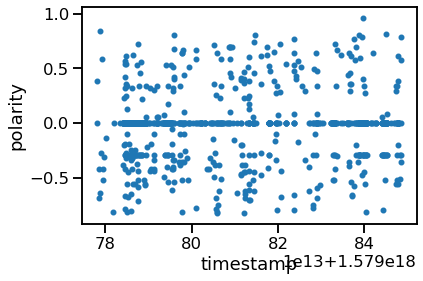

In [502]:
around.plot(kind="scatter", x="timestamp", y="polarity")

In [503]:
around.groupby("user_id")["id"].count()

user_id
282654181              504
806262883298381824     127
914137866581635072      52
934526329650909184      28
1072572977940742144     40
1137428830732337154     39
1216496684001300482     94
Name: id, dtype: int64

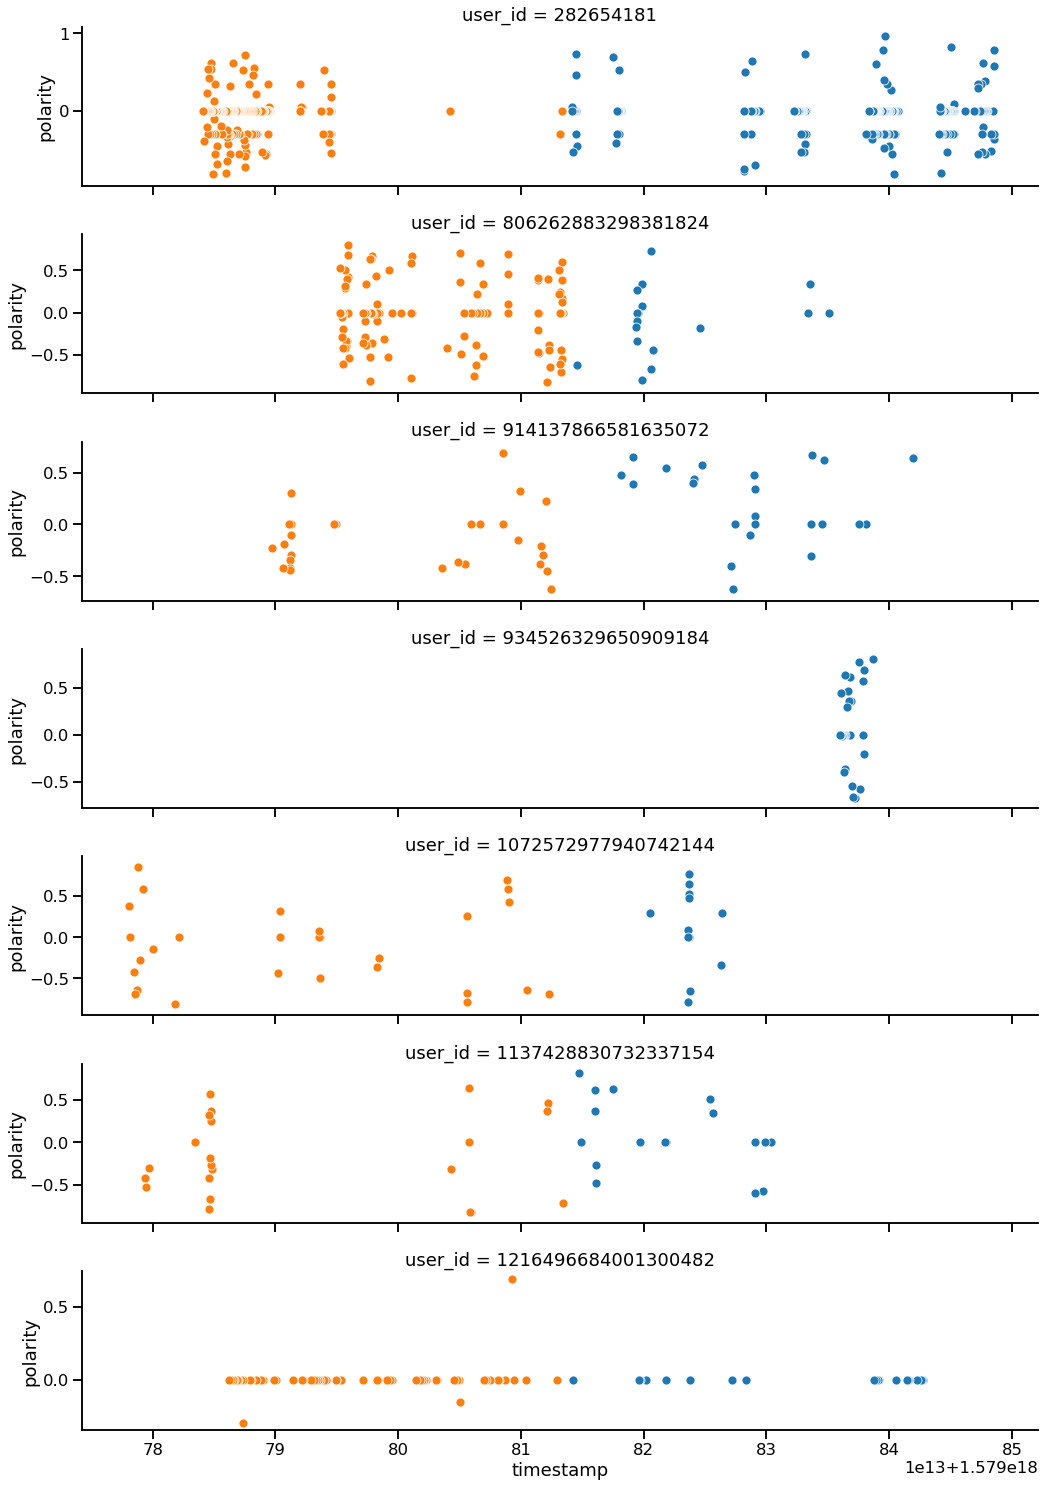

In [504]:
g = sns.FacetGrid(around, row="user_id", aspect=5, hue="before", sharey=False)

g = g.map(sns.scatterplot, "timestamp", "polarity")